TD3 : Let's play with faces  
Part 2 - Transfert Learning (Train classifier)

S. Delprat, INSA Hauts-de-France    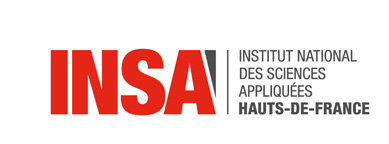


We are now going to train a new classification head from the embedding that are stored on a file.  
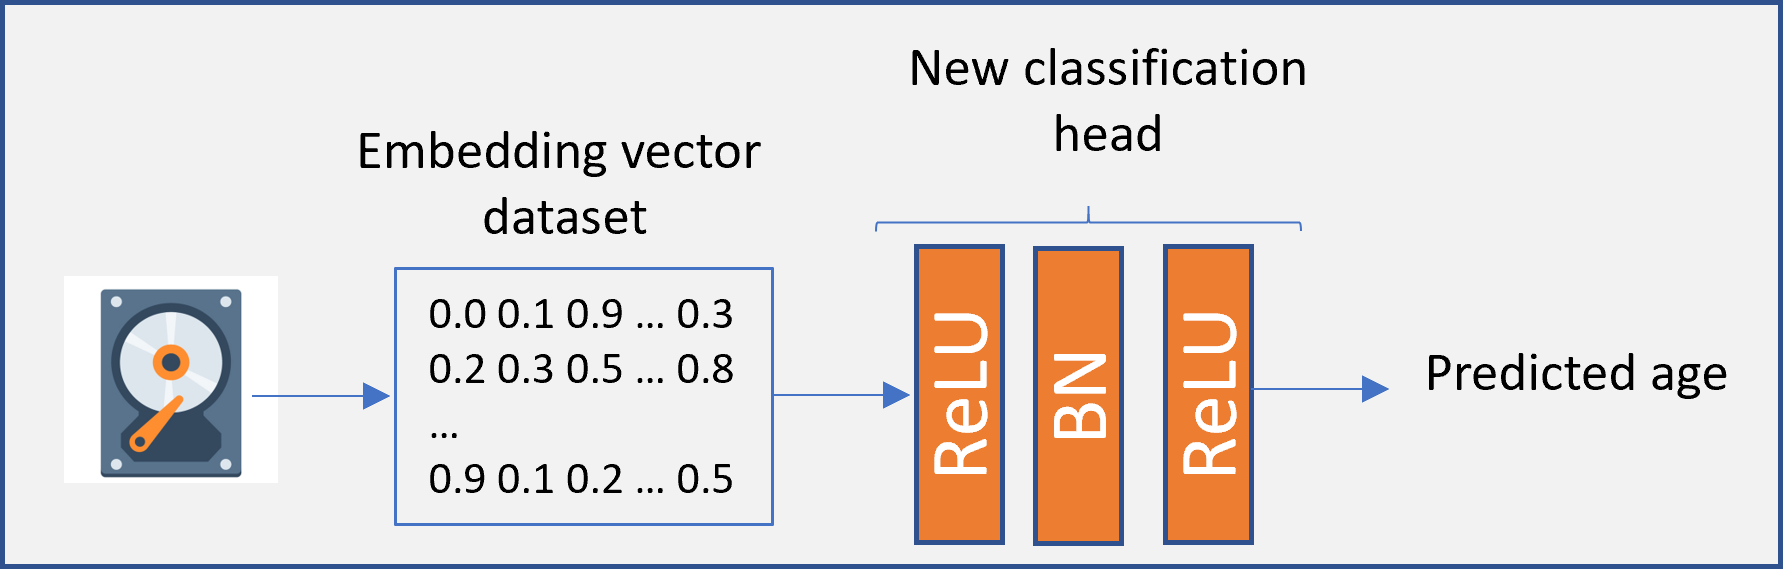

In [1]:
# !pip install torchinfo
import torch
import torchvision
import seaborn as sns
from   sklearn.metrics import classification_report, confusion_matrix
import os
import zipfile
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
import math
from glob import glob
from PIL import Image
import random
from torchinfo import summary
import numpy as np
from IPython.display import FileLink
import pandas as pd
from datetime import datetime
import os
from torchvision.transforms import v2
import pickle
import shutil
import copy

*Q1.* Mount google drive and defines the path to the binary file containing your data

In [2]:
binaryEmbeddingFile='../models/td3/result/Part1/embedding.bin'

# Check if the file exists
if not os.path.exists(binaryEmbeddingFile):
    raise Exception(f"File {binaryEmbeddingFile} not found")
else :
    print(f"Embedding file found: {binaryEmbeddingFile}")

Embedding file found: ../models/td3/result/Part1/embedding.bin


Random seed

In [3]:
DEFAULT_RANDOM_SEED=42
def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# basic + tensorflow + torch
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

seedEverything()

Configuration of the hyperparameters

*Q2.* Chose a batchsize  
What is the size of the embedding vector ?
=> explain the your choice in a Text cell below

** You explanations here **

In [4]:
experimentName                          = "Part2"
maxImgsTrain, maxImgsValid, maxImgsTest = None, None, None
batchSize                               = 1024
learningRate                            = 0.001
numEpoch                                = 100        # number of epoch for the training
resultFolder                            =  os.path.join("../models/td3/result", experimentName)

In [6]:
if not os.path.isdir(resultFolder):
    os.makedirs(resultFolder)

Check cuda availability (if not available, please select GPU P100 as an accelerator and NOT the dual T4)

In [8]:
torch.__version__

'2.2.2+cu121'

In [9]:
if torch.cuda.is_available():
  print('cuda is available')
  device='cuda'
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

    device_cap = torch.cuda.get_device_capability()
    print('device capability : ',torch.cuda.get_device_capability())
else:
  print('cuda is not available')
  device='cpu'

cuda is available
NVIDIA GeForce GTX 1050
device capability :  (6, 1)


# Load embeddings

*Q3.*: load the pickle file <code>binaryEmbeddingFile</code>

In [10]:
# Load the embeddings and labels from the file
with open(binaryEmbeddingFile, 'rb') as f:
    train_embeddings, train_ages, train_kept_indices, valid_embeddings, valid_ages, valid_kept_indices, test_embeddings, test_ages, test_kept_indices = pickle.load(f)

# Check the shapes and types
print(f"Train embeddings: {train_embeddings.shape}, Train ages: {train_ages.shape}")
print(f"Valid embeddings: {valid_embeddings.shape}, Valid ages: {valid_ages.shape}")
print(f"Test embeddings: {test_embeddings.shape}, Test ages: {test_ages.shape}")
print(f"Embedding data type: {train_embeddings.dtype}")

*Q4.* create a dataset that outputs the embedding, the perceived age and the filename  
The embedding vector & the perceived age should be <code>float32</code> tensor

In [20]:
# Create a dataset that outputs the embedding, the perceived age and the filename  
# The embedding vector & the perceived age should be float32 tensor
from torch.utils.data import Dataset

class embeddingDataset(torch.utils.data.Dataset):
  def __init__(self, embeddings, perceivedAges, fileNames):
    self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
    self.perceivedAges = torch.tensor(perceivedAges, dtype=torch.float32)
    self.fileNames = fileNames

    assert len(self.embeddings) == len(self.perceivedAges)
    assert len(self.embeddings) == len(self.fileNames)

  def __len__(self):
    return len(self.embeddings)

  def __getitem__(self, idx):
    return self.embeddings[idx], self.perceivedAges[idx], self.fileNames[idx]

*Q5.* creeate 3 datasets for training, validation and testing along with the 3 corresponding dataloaders

In [21]:
# Create 3 datasets for training, validation and testing along with the 3 corresponding dataloaders
train_dataset = embeddingDataset(train_embeddings, train_ages, [])
valid_dataset = embeddingDataset(valid_embeddings, valid_ages, [])
test_dataset = embeddingDataset(test_embeddings, test_ages, [])

/tmp/ipykernel_12615/1647910924.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
/tmp/ipykernel_12615/1647910924.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.perceivedAges = torch.tensor(perceivedAges, dtype=torch.float32)


# Define a model for the classification head

*Q6.* Create the <code>myClassificationHead</code> used to predict the age from the embedding vector.

Do not use any convolutional layer... it is just a prediction head


In [22]:
# Create the myClassificationHead used to predict the age from the embedding vector.

# Do not use any convolutional layer... it is just a prediction head
class myClassificationHead(torch.nn.Module):
    def __init__(self,nFeat):
        super(myClassificationHead, self).__init__()
        self.fc1 = torch.nn.Linear(nFeat, 64)
        self.fc2 = torch.nn.Linear(64, 1)


    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


*Q7.* Create one instance of myClassificationHead

In [23]:
# Create one instance of myClassificationHead
nFeat = train_embeddings.shape[1]
classificationHead = myClassificationHead(nFeat).to(device)

# Training loop

*Q6.* Define the optimizer & the criterion  
If the model is not of the <code>device</code>, send it!

What are the possible criterion for the considered task. Why? Provide you answer in the text cell below

**Explain the possible criterion here**

In [24]:
# Define the optimizer & the criterion  
# If the model is not of the device, send it!

optimizer = torch.optim.Adam(classificationHead.parameters(), lr=learningRate)
criterion = torch.nn.L1Loss()

*Q7.* Program a training loop  
You may adapt the code fromt he previous exercise session

In [25]:
history = {"train_loss": [],
           "train_rmse": [],
           "train_x": [],
           "val_loss": [],
           "val_rmse": [],
           "val_x":[]
  }
bestValidationLoss=math.inf

NB: to store a copy of an existing model, you must use <code>modele2 = copy.deepcopy(modele1)</code>  
The code <code>modele2=modele1</code> simply create a reference of <code>modele1</code> (i.e. modifying <code>modele1</code> will also modify <code>modele2</code>!)


In [26]:
# Training loop
for epoch in range(numEpoch):
    classificationHead.train()
    train_loss = 0
    train_rmse = 0
    train_x = 0
    for embeddings, ages, _ in train_dataset:
        embeddings, ages = embeddings.to(device), ages.to(device)
        optimizer.zero_grad()
        outputs = classificationHead(embeddings)
        loss = criterion(outputs, ages)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_rmse += torch.sqrt(loss).item()
        train_x += 1
    train_loss /= train_x
    train_rmse /= train_x
    history["train_loss"].append(train_loss)
    history["train_rmse"].append(train_rmse)
    history["train_x"].append(epoch)

    classificationHead.eval()
    val_loss = 0
    val_rmse = 0
    val_x = 0
    for embeddings, ages, _ in valid_dataset:
        embeddings, ages = embeddings.to(device), ages.to(device)
        outputs = classificationHead(embeddings)
        loss = criterion(outputs, ages)
        val_loss += loss.item()
        val_rmse += torch.sqrt(loss).item()
        val_x += 1
    val_loss /= val_x
    val_rmse /= val_x
    history["val_loss"].append(val_loss)
    history["val_rmse"].append(val_rmse)
    history["val_x"].append(epoch)

    if val_loss < bestValidationLoss:
        bestValidationLoss = val_loss
        torch.save(classificationHead.state_dict(), os.path.join(resultFolder, "bestModel.pth"))

    print(f'Epoch {epoch+1}/{numEpoch} - Train Loss: {train_loss:.4f} - Train RMSE: {train_rmse:.4f} - Val Loss: {val_loss:.4f} - Val RMSE: {val_rmse:.4f}')

ZeroDivisionError: division by zero

*Q8.* Save the obtained model

In [ ]:
Your code here

*Q9.* Plot training curves & save them to "trainingCurves.png"

In [ ]:
Your code here

# Test result analysis

*Q10.* Predict data over the test dataset  
Do not forget to use the best  model obtained during training
The outcome are 2 python list <code>allYtest</code> and <code>allYtrue</code> that contains the predicted age and the real ground thrue value

In [ ]:
Your code here

*Q11.* Compute the prediction error and display its RMSE value

In [ ]:
Your code here

*Q12.* Display predicted age vs real age and error distribution

In [ ]:
Your code here